In [13]:
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit

from pcygni_profile import PcygniCalculator
import astropy.units as units
import astropy.constants as csts
from scipy.interpolate import interp1d

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        
        
import math
pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

def lum_dist(p, psig, beta, dbeta, n_days=1.43, dt=0.): #propagate bb to luminosity distance 
    theta = 2*np.sqrt(p[1]*10**(7)/np.pi)
    dtheta = 1/np.sqrt(p[1])*np.sqrt(10**(7)/np.pi)*psig[1]

    v = beta*c/2; dv = dbeta*c/2 #factor of 2
    t = (n_days-dt) * (3600*24)
    r = v*t; dr = dv*t 
    
    D = r/theta*2# factor of 2 
    dD = ( (r/theta**2*2*dtheta)**2 + (dr/theta*2)**2 )**(1/2)

    D_mpc = D*(3.2408e-23)
    dD_mpc = dD*(3.2408e-23)
    
    return D_mpc, dD_mpc

n_days = [1.427, 2.417, 3.413, 4.403]


In [25]:
def pcyg(t0, vmax, vphot, tauref, vref, ve, lam0, wl):

    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=vmax * csts.c,
                                 vphot=vphot * csts.c, tauref=tauref, vref=vref * csts.c, ve=ve * csts.c,
                                 lam0=lam0 * units.AA)

    x, pcyg = prof_calc.calc_profile_Flam(npoints=25, mode="both")
    f = interp1d(x, pcyg, bounds_error=False, fill_value=1)
    return f(wl)

def planck(wav, T, N, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def residual(pars, t, data=None, error=None):
    """
    Objective function which calculates the residuals. Using for minimizing.
    """

    # Unpack parameter values
    if type(pars) is list or isinstance(pars, np.ndarray):
        T, N, beta = pars[0], pars[1], pars[2]
        t0, vmax, tauref1, tauref2, tauref3, vref, ve, occult1, occult2 = pars[3], pars[4], pars[5], pars[6], pars[7], pars[8], pars[9], pars[10], pars[11]
        #amp1, amp2, cen1, cen2, sig1, sig2 = pars[12], pars[13], pars[14], pars[15], pars[16], pars[17]
    else:
        v = pars.valuesdict()
        T, N, beta = v["T"], v["N"], v["beta"]
        t0, vmax, tauref1, tauref2, tauref3, vref, ve, occult2 = v["t0"], v["vmax"], v["tauref1"], v["tauref2"], v["tauref3"], v["vref"], v["ve"], v["occult2"]
        #amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    # Construct model components
    # P-cygnis
    # Sr
    # 10506.3653
    #pcyg_prof1 = pcyg(t0, vmax, beta, tauref1, vref, ve, 4077.709, t)
    #pcyg_prof2 = pcyg(t0, vmax, beta, tauref1, vref, ve, 4215.519, t)
    pcyg_prof3 = pcyg(t0, vmax, beta, tauref2, vref, ve, 10036.65, t)
    pcyg_prof4 = pcyg(t0, vmax, beta, 8.1*tauref2, vref, ve, 10327.311, t)
    pcyg_prof5 = pcyg(t0, vmax, beta, 4.7*tauref2, vref, ve, 10914.887, t)

    # Blackbody
    # R = (beta * c.c *t0 * u.s).to(u.cm).value
    bb = planck(t, T, N)

    # Gaussians
    #gau1 = models.Gaussian1D.evaluate(t, 1e-17*amp1, cen1, sig1)
    #gau2 = models.Gaussian1D.evaluate(t, 1e-17*amp2, cen2, sig2)

    # Make model
    pcyg_prof = pcyg_prof3*pcyg_prof4*pcyg_prof5#*pcyg_prof6*pcyg_prof7*pcyg_prof8*pcyg_prof9
    print(pcyg_prof)
    pcyg_prof[pcyg_prof > 1] = (pcyg_prof[pcyg_prof > 1] - 1.)*occult2 + 1.
    model = bb*pcyg_prof #+ gau1 + gau2


    # pcyg_prof_uv = pcyg_prof1*pcyg_prof2
    # pcyg_prof_uv[pcyg_prof_uv > 1] = (pcyg_prof_uv[pcyg_prof_uv > 1] - 1.)*occult1 + 1.
    # pcyg_prof_ir = pcyg_prof3*pcyg_prof4*pcyg_prof5*pcyg_prof6*pcyg_prof7*pcyg_prof8*pcyg_prof9
    # pcyg_prof_ir[pcyg_prof_ir > 1] = (pcyg_prof_ir[pcyg_prof_ir > 1] - 1.)*occult2 + 1.
    # model = bb*pcyg_prof_uv*pcyg_prof_ir + gau1 + gau2

    model[np.isnan(model)] = 1

    if data is None:
        return model
    if error is None:
        return (model - data)
    return (model - data)/error

In [32]:
path = '.\AT2017gfo\AT2017gfo\dereddened+deredshifted_spectra' 
files = os.listdir(path)

x = np.loadtxt(path+'/'+files[2])
exc_reg_2 = (~((x[:,0] > 13100) & (x[:,0] < 14360))) & (~((x[:,0] > 17550) & (x[:,0] < 19000))) & \
          (~((x[:,0] > 5330) & (x[:,0] < 5740))) & (~((x[:,0] > 9840) & (x[:,0] < 10300))) & \
          (x[:,0] > 4000) & (x[:,0] < 22500)

wl, flux, error = x[:,0][exc_reg_2], x[:,1][exc_reg_2], x[:,3][exc_reg_2]

In [140]:
def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, v1=0.2, ve=0.2, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=v1 *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

def planck_with_mod(wav, T, N, v_out, v_phot, tau=0.55, occul = 1.5,#amp1 = 2, cen1=15500, sig1=250, 
                    ve=0.2, vref=0.22, t0=120960, lam=10506.3653, z_pec=0.): #blackbody
    wav = wav*(1+z_pec)
    a = 2.0*h*pi*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    
    
    pcyg_prof3 = pcyg(wav, v_out, v_phot, tau     , 10036.65, v1=vref, ve=ve , t0=t0)
    pcyg_prof4 = pcyg(wav, v_out, v_phot, 8.1*tau , 10327.311,v1=vref, ve=ve , t0=t0)
    pcyg_prof5 = pcyg(wav, v_out, v_phot, 4.7*tau , 10914.887,v1=vref, ve=ve , t0=t0)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    #correction = p_cygni_line_corr(wav, v_out, v_phot, tau, lam, v1=vref, ve=ve, t0=t0)
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    # Gaussians
    #gau1 = gaussian(wav, 1e-17*amp1, cen1, sig1)
    #gau2 = gaussian(wav, 1e-17*amp2, cen2, sig2)
    #gau2 = models.Gaussian1D.evaluate(t, 1e-17*amp2, cen2, sig2)
    
    intensity = intensity*correction
    return N*intensity #+gau1


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref)
    
    if data is None:
        return model
    return (model - data)/error


#### Fit structure

In [99]:
p_i, cov_i = curve_fit(planck_with_mod, wl[]*10**(-10), flux, sigma = error,
                   p0 = [3111, 2*10**(-29),0.27,0.23, 0.5, 2])  #,
#                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)

C:\Users\asnep\Downloads\Kilonova\pcygni_profile.py:489: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  Fnu = 2. * np.pi * integ.quad(self._Iemit, 0, pmax, args=(z, mode))[0]


In [108]:
p_i

array([3.11383748e+03, 1.77738046e-29, 2.66257060e-01, 2.33893079e-01,
       2.99736267e+00, 2.06961979e+00])

In [123]:
p = lmfit.Parameters()
#dir(p), p, 
OB = 'OB3'
with open("./data/%s_init.json"%OB, 'r') as infile:
        p.load(infile)

mi = lmfit.minimize(residual, p, method='Nelder', args=(wl*1e-10, flux, error))

11854655.006516187
11854655.006516187
3.2324866428742444e+57
11854655.006516187
11854655.006516187
11854655.006516187
11854655.006516187
2.0445266028242334e+57
5.713558756248819e+56
7.185872408064298e+56
1.511511228803048e+56
1.6951257448188427e+56
3.8879368670683653e+55
4.117351745953164e+55
9.859693090373381e+54
1.0146383466031446e+55
2.482622936426702e+54
2.5184550607674916e+54
6.228809714369741e+53
6.273603590237374e+53
1.559994235294033e+53
1.5655925637882292e+53
3.9034800022948996e+52
3.910477434912742e+52
9.76306933787494e+51
9.771815308578465e+51
2.441312622026227e+51
2.4424069414999752e+51
6.103966626708017e+50
6.105333144219639e+50
1.5260770120876737e+50
1.526247769640261e+50
3.8153007635626936e+49
3.8155137307058596e+49
9.538386801938971e+48
9.538647328823785e+48
2.3846120902705584e+48
2.3846452478202294e+48
5.961550876984244e+47
5.9615925164183664e+47
1.4903903912578661e+47
1.4903955508666234e+47
3.7259791965028154e+46
3.7259856364004724e+46
9.314952059383704e+45
9.31496007

82425.71964647938
82416.63913993086
82416.53317619549
82429.23455447983
82424.05130332877
82415.08550200575
82433.62998882477
82413.54568523807
82420.92113792805
82414.61623351382
82416.51597021261
82413.50891654355
82416.78236442732
82414.04527749328
82423.7158942589
82413.27327820507
82416.97315977367
82413.83715128724
82413.60315095536
82414.18325211857
82413.08107457006
82414.01309720003
82412.9762774423
82414.43951933626
82412.97486058749
82413.61127083904
82412.93640106644
82412.48258325444
82413.08429329992
82413.41991617599
82412.7710321387
82413.75165888492
82412.73502702144
82413.70213823485
82412.63320484158
82412.56066194552
82412.76929263299
82412.72479655386
82412.73234418863
82412.8337491325
82412.6735254096
82412.34452805162
82412.54399390485
82412.30815713455
82412.8741418297
82412.81612348247
82412.41769489262
82412.34382230838
82412.45220369798
82412.27642062453
82412.44245201083
82412.23505990366
82412.6575085767
82412.46594479546
82412.28433669878
82412.06783893642

In [ ]:
lum_dist([0,mi.params['N'].value], [0,0.1*mi.params['N'].value],
         mi.params['vphot'].value,0.1*mi.params['vphot'].value, 
         n_days=3.41)

In [136]:
with open("./data/%s.json"%OB, 'w') as outfile:
    mi.params.dump(outfile)

#### Markow Chain Monto Carlo - Sample Space with emcee

In [ ]:
def lnprob(pars):
    """
    This is the log-likelihood probability for the sampling.
    """
    model = residual(pars, wl*1e-10)
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

mini = lmfit.Minimizer(lnprob, p)

nwalkers = 20
v = p.valuesdict()
res = mini.emcee(nwalkers=nwalkers, burn=100, steps=200, thin=1, params=p, seed=12345, workers = 6)

 36%|███▌      | 71/200 [11:47<22:19, 10.38s/it]

In [146]:
import pickle

with open("./data/%s_emcee.json"%OB, 'w') as outfile:
    res.params.dump(outfile)

with open("./data/%s_emcee.pkl"%OB, 'wb') as outfile:
    pickle.dump(res, outfile)

In [149]:
res.params['N']

<Parameter 'N', value=-1.046949701286293e-28 +/- 2.29e-27, bounds=[-inf:inf]>

In [154]:
mi

In [155]:
res

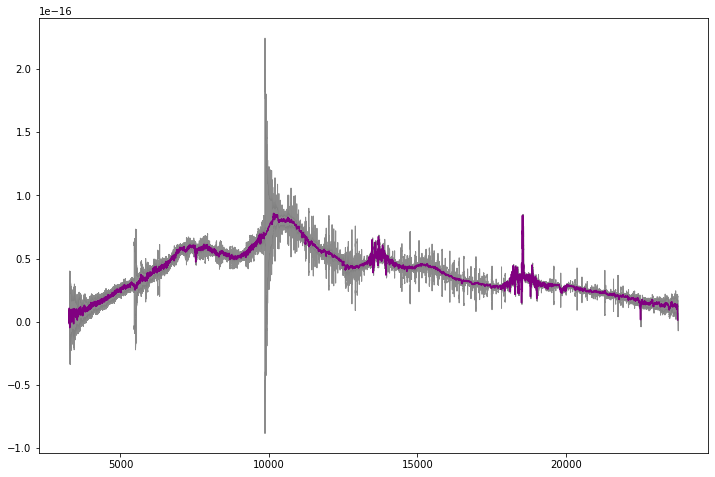

In [93]:
fig,ax = plt.subplots(figsize=(12,8))
plt.plot(x[:,0], x[:,1], label='X-shooter spectra', color='purple')
#p, cov = curve_fit(planck, x[:,0][exc_reg]*10**(-10), x[:,1][exc_reg], sigma = x[:,3][exc_reg],
#                   p0 = [5200, 5*10**(-30)], absolute_sigma=True)
#psig = np.sqrt(np.diagonal(cov)) #*40

#print(p, psig)

#plt.plot(x[:,0], planck(x[:,0]*10**(-10),*p), ls='--', color='k', label='Blackbody-fit')
plt.fill_between(x[:,0], x[:,1]-x[:,3], x[:,1]+x[:,3], 
                 color='grey', alpha=0.9)